In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras import applications, layers, losses, optimizers, Model
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from textwrap import wrap


In [4]:
PATH = '/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/'
PATH_TO_IMG = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train_images/'
PATH_TO_TEST = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/test_images/'

In [5]:
os.listdir(PATH)

['test_images',
 'test.csv',
 'train.csv',
 'train_images',
 'sample_submission.csv']

In [6]:
len(os.listdir(PATH_TO_IMG))

32411

In [8]:
# Dingkun's preprocessing
COMPUTE_CV = True
if len(pd.read_csv(PATH + 'test.csv')) > 3: COMPUTE_CV = False

if COMPUTE_CV:
    dataset = pd.read_csv(PATH + 'train.csv')
    tmp = dataset.groupby('label_group').posting_id.agg('unique').to_dict() 
    dataset['target'] = dataset.label_group.map(tmp) # map the posting_ids that have same image
else:    
    dataset = pd.read_csv(PATH + 'test.csv')

In [12]:
len(dataset)

34250

In [10]:
# Dingkun's preprocessing
def show_random_img():
    # choose randomly two instances per each class
    labels_to_show = np.random.choice(dataset.label_group.unique(), 
                                      replace=False, size=27)
    img_to_show = []
    for label in labels_to_show:
        rows = dataset[dataset.label_group==label].copy()
        pair = np.random.choice([i for i in range(len(rows))], 
                                    replace=False, size=2)
        img_pair = rows.iloc[pair][['image', 'title']].values
        
        img_to_show += list(img_pair)
    
    fig, axes = plt.subplots(figsize = (18, 12), nrows=4,ncols=6)
    for imp, ax in zip(img_to_show, axes.ravel()):
        img = cv2.imread(PATH_TO_IMG + imp[0])
        title = '\n'.join(wrap(imp[1], 20))
        ax.set_title(title)
        ax.imshow(img)
        ax.axis('off')

    fig.tight_layout()

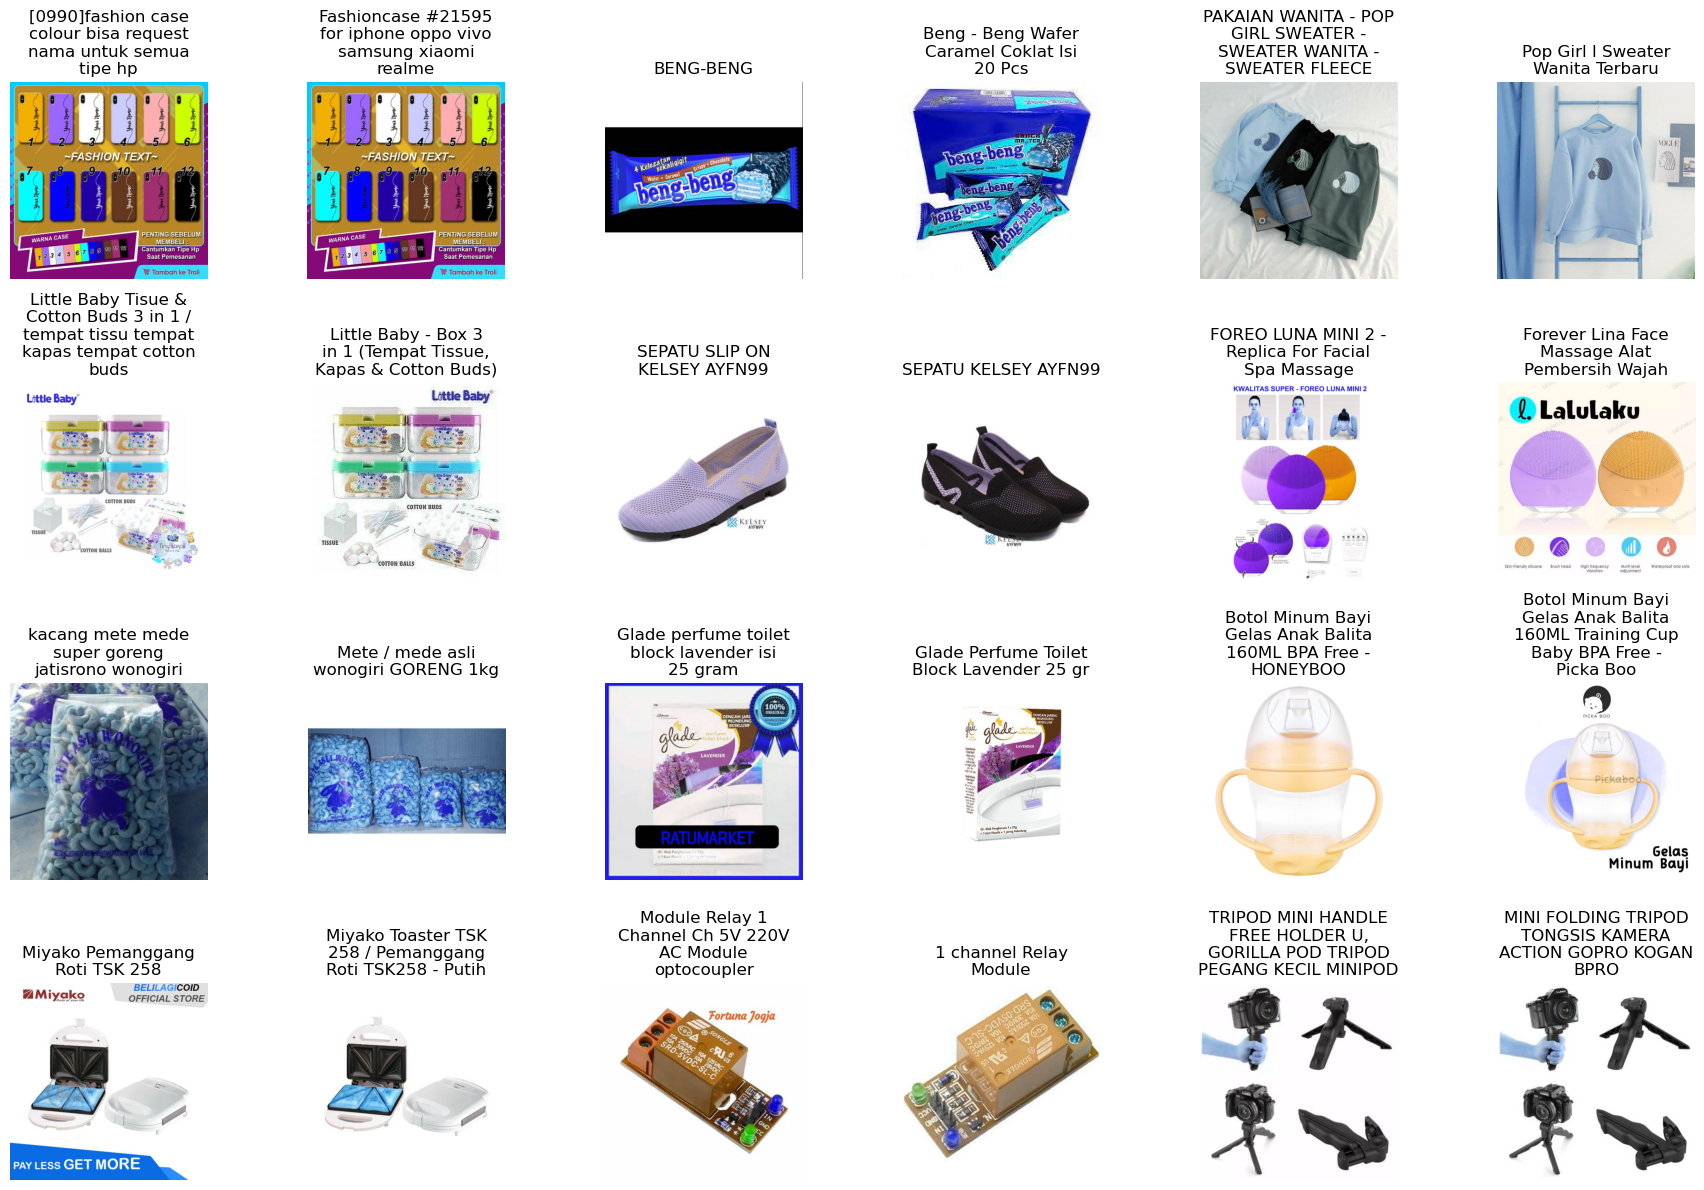

In [11]:
if COMPUTE_CV:
    show_random_img()

In [15]:
num_classes = len(train_ds.class_names)
print(f"We have {num_classes} classes.")

We have 11014 classes.


# Trying 1 epoch

In [35]:
input_shape = (256, 256, 3)
num_classes = 11014

resnet = ResNet50(include_top=True, weights=None, input_shape=input_shape, classes=num_classes)


In [36]:
resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [38]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data/',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="training",
    seed=42,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data/',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="validation",
    seed=42,
)


Found 32459 files belonging to 11014 classes.
Using 25968 files for training.
Found 32459 files belonging to 11014 classes.
Using 6491 files for validation.


In [42]:
epochs=1

In [41]:
checkpoint_filepath = '/workspaces/Shopee-Price-Match-Guarantee/30_results/2_ResNet50/checkpoints/'


In [43]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = resnet.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback])


812/812 [==============================] - 2920s 4s/step - loss: 8.8283 - accuracy: 0.0022 - val_loss: 10.0576 - val_accuracy: 0.0029


In [44]:
# Evaluate the model on the validation dataset
val_loss, val_acc = resnet.evaluate(val_ds)

# Print the validation accuracy
print("Validation accuracy:", val_acc)


203/203 [==============================] - 186s 915ms/step - loss: 10.0576 - accuracy: 0.0029
Validation accuracy: 0.0029271298553794622
